## NBA simulatore

- [x] calendario partite 2021 > NBA21sched  
- [x] PREDITTORE PER TUTTA STAGIONE .. loop , utilizza cfr di PLUS_MINUS_RANK stagione passata per squadra 
- [x] stats medie per squadra > AVG_TEAM_STATS_PRESEASON
- [x] fare lista partite per data 
- [x] provato predittore su partite passate = 68% 
- [x] imparatto a ottimizzare funzione, ma scritta cosi non ha senso . ovvio che massimizzo se le indovino tutte! 
- [ ] nuova funzione !! 
- [ ] provare fantasywidget per singoli giocatori .. fatto sotto, affinare 
- [ ] stato infortuni ? 
- [ ] arricchire criterio .. - giocatori on fire, striscia positiva , salute , +-, , efficienza

- 201220 minimizzare chiamate facendo cella con chiamata che salva su DF e altra cella per lavorare sul DF 
- 201220 aggiunto ODDS ( sistemare data ) 
- 201220 corretto formula guadagno 
- 201220 dubbio. il mio algoritmo non puo vincere contro odds

- https://github.com/swar/nba_api/blob/master/docs/table_of_contents.md
- https://app.slack.com/client/TGCSU1HDW/CGDKENXGS/thread/CGDKENXGS-1607890992.090800


## LOAD NBA SEASON SCHEDULE 20-21 > NBA21sched

In [257]:
import numpy as np
import pandas as pd

df = pd.read_csv("NBA2021schedule.csv",sep=";")
df=df.loc[df['Value'].str.startswith('@') == False]
df=df.rename(columns={"Value": "AWAY", "Attribute": "HOME"})
df = df[['GAMEDATE','HOME','AWAY']]
df['AWAY'] = df['AWAY'].apply(lambda x: x.upper())
df['HOME'] = df['HOME'].apply(lambda x: x.upper())
df= df.reset_index()
df['HOME'] = df['HOME'].str.replace('PHO','PHX')
df['AWAY'] = df['AWAY'].str.replace('PHO','PHX')
df['HOME'] = df['HOME'].str.replace('NOR','NOP')
df['AWAY'] = df['AWAY'].str.replace('NOR','NOP')
df['HOME'] = df['HOME'].str.replace('NO','NOP')
df['AWAY'] = df['AWAY'].str.replace('NO','NOP')
df['HOME'] = df['HOME'].str.replace('NY','NYK')
df['AWAY'] = df['AWAY'].str.replace('NY','NYK')
df['HOME'] = df['HOME'].str.replace('SA','SAS')
df['AWAY'] = df['AWAY'].str.replace('SA','SAS')
df['HOME'] = df['HOME'].str.replace('UTH','UTA')
df['AWAY'] = df['AWAY'].str.replace('UTH','UTA')

NBA21sched = df
print(NBA21sched.shape)
NBA21sched.head(1)

NBA21sched.nunique()

(558, 4)


index       558
GAMEDATE     72
HOME         30
AWAY         30
dtype: int64

## PREDICT WIN 
### funz basata su basato SU PLUS_MINUS_RANK di AVG_TEAM_STATS_PRESEASON

In [2]:
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd 

teams = pd.DataFrame(teams.get_teams())
output = leaguedashteamstats.LeagueDashTeamStats(last_n_games='0', measure_type_detailed_defense='Base', month='0', opponent_team_id=0, pace_adjust='N', per_mode_detailed='Totals', period='0', plus_minus='N', rank='N', season='2019-20', season_type_all_star='Regular Season', conference_nullable='', date_from_nullable='', date_to_nullable='', division_simple_nullable='', game_scope_simple_nullable='', game_segment_nullable='', league_id_nullable='', location_nullable='', outcome_nullable='', po_round_nullable='', player_experience_nullable='', player_position_abbreviation_nullable='', season_segment_nullable='', shot_clock_range_nullable='', starter_bench_nullable='', team_id_nullable='', two_way_nullable='', vs_conference_nullable='', vs_division_nullable='').get_data_frames()

df = pd.DataFrame(output[0])
AVG_TEAM_STATS_PRESEASON = df

def PREDICT(dfz,TEAM1,TEAM2):
    A = teams.loc[teams['abbreviation'] == TEAM1]['id'].values[0]
    B = teams.loc[teams['abbreviation'] == TEAM2]['id'].values[0]
    A1 = (df.loc[df['TEAM_ID'] == A]['PLUS_MINUS_RANK'].values[0])
    A2 = (df.loc[df['TEAM_ID'] == A]['TEAM_NAME'].values[0])
    B1 = (df.loc[df['TEAM_ID'] == B]['PLUS_MINUS_RANK'].values[0])
    B2 = (df.loc[df['TEAM_ID'] == B]['TEAM_NAME'].values[0])
    if A1<B1:
        win=TEAM1
    else:
        win=TEAM2
    return(win,min(A1,B1),max(A1,B1))

#print(PREDICT(AVG_TEAM_STATS_PRESEASON,'BOS','ORL'))

i=0
for index, row in NBA21sched.iterrows():
    TEAM1 = row['HOME'][:3]
    TEAM2 = row['AWAY'][:3]
    OUT = PREDICT(AVG_TEAM_STATS_PRESEASON,TEAM1,TEAM2)
    NBA21sched.at[i, 'PREDICT'] = OUT[0]
    NBA21sched.at[i, 'WIN_RANK'] = OUT[1]
    NBA21sched.at[i, 'LOSE_RANK'] = OUT[2]
    i=i+1

print(NBA21sched.nunique())
NBA21sched

index        558
GAMEDATE      72
HOME          30
AWAY          30
PREDICT       27
WIN_RANK      26
LOSE_RANK     27
dtype: int64


,index,GAMEDATE,HOME,AWAY,PREDICT,WIN_RANK,LOSE_RANK
0,0,22/12/2020,BKN,GSW,BKN,15.0,30.0
1,3,22/12/2020,LAL,LAC,LAC,2.0,5.0
2,5,23/12/2020,BOS,MIL,MIL,1.0,3.0
3,7,23/12/2020,CHI,ATL,CHI,22.0,29.0
4,8,23/12/2020,CLE,CHA,CHA,27.0,28.0
...,...,...,...,...,...,...,...
553,1106,04/03/2021,MEM,MIL,MIL,1.0,17.0
554,1109,04/03/2021,NOP,MIA,MIA,7.0,20.0
555,1111,04/03/2021,POR,SASC,SAS,18.0,19.0
556,1113,04/03/2021,SAS,OKC,OKC,12.0,18.0


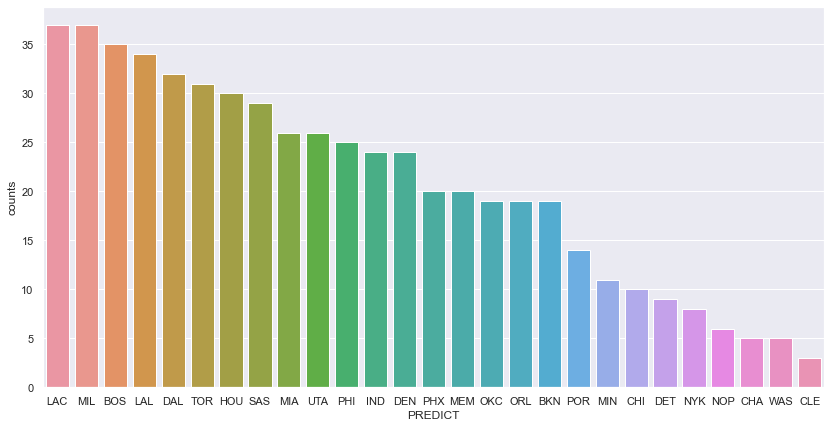

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

NBA21schedP = NBA21sched.groupby(['PREDICT']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

sns.set(rc={'figure.figsize':(14,7)})
ax = sns.barplot(x='PREDICT', y='counts', data=NBA21schedP)
plt.show()


## STAS MEDIE PER GIOCATORE > AVG_PLAYER_STATS_PRESEASON

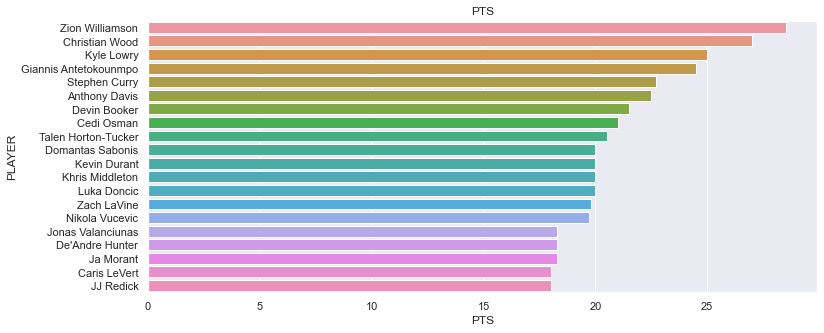

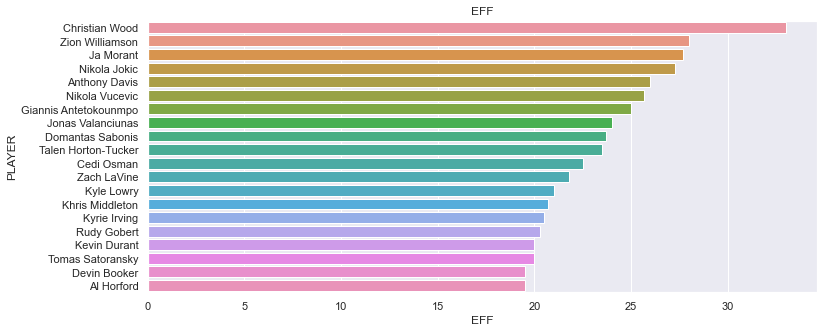

In [6]:
from nba_api.stats.endpoints import leagueleaders
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

output = leagueleaders.LeagueLeaders(league_id='00', per_mode48='PerGame', scope='RS', season='2020-21', season_type_all_star='Pre Season', stat_category_abbreviation='PTS', active_flag_nullable='').get_data_frames()
AVG_PLAYER_STATS_PRESEASON = pd.DataFrame(output[0])

plt.title('PTS')
toplot = AVG_PLAYER_STATS_PRESEASON.sort_values(by='PTS', ascending=False).head(20)
sns.set(rc={'figure.figsize':(12,5)})
ax = sns.barplot(x='PTS', y='PLAYER', data=toplot)
plt.show()

plt.title('EFF')
toplot = AVG_PLAYER_STATS_PRESEASON.sort_values(by='EFF', ascending=False).head(20)
sns.set(rc={'figure.figsize':(12,5)})
ax = sns.barplot(x='EFF', y='PLAYER', data=toplot)
ax.set_xlabel('EFF')
plt.show()


<div class="alert-warning">
        
# BACKUP GOOD
     
</div>

## Getting Player & Team Ids

In [8]:
from nba_api.stats.static import players
player_dict = players.get_players()

# Use ternary operator or write function 
# Names are case sensitive
bron = [player for player in player_dict if player['full_name'] == 'LeBron James'][0]
bron_id = bron['id']

# find team Ids
from nba_api.stats.static import teams 
teams = teams.get_teams()
GSW = [x for x in teams if x['full_name'] == 'Golden State Warriors'][0]
GSW_id = GSW['id']



1610612744

## Getting Game Data

In [5]:
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

gamelog_bron = playergamelog.PlayerGameLog(player_id='2544', season = '2018')
df_bron_games_2018 = gamelog_bron.get_data_frames()
df = pd.DataFrame(df_bron_games_2018[0])
print(df.shape)


(55, 27)


In [6]:
import numpy as np

df["year"] = df["GAME_DATE"].str[-4:]
df.head()

df2 = pd.pivot_table(df,index=["year"],columns=["WL"],values=["PTS"],aggfunc=[np.mean,np.sum,np.max,len])

df3=df2.unstack()
df2.head()

mean          sum      amax     len    
            PTS          PTS       PTS     PTS    
WL            L       W    L    W    L   W   L   W
year                                              
2018  25.642857  28.450  359  569   36  51  14  20
2019  26.769231  28.625  348  229   33  36  13   8

In [1]:
from nba_api.stats.static import teams

import pandas as pd
df = pd.DataFrame(teams.get_teams())
df.head()


,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [8]:
from nba_api.stats.static import players
import pandas as pd

df = pd.DataFrame(players.get_players())
print(df.head())
print(df.shape)

      id            full_name first_name     last_name  is_active
0  76001       Alaa Abdelnaby       Alaa     Abdelnaby      False
1  76002      Zaid Abdul-Aziz       Zaid    Abdul-Aziz      False
2  76003  Kareem Abdul-Jabbar     Kareem  Abdul-Jabbar      False
3     51   Mahmoud Abdul-Rauf    Mahmoud    Abdul-Rauf      False
4   1505    Tariq Abdul-Wahad      Tariq   Abdul-Wahad      False
(4501, 5)


In [9]:
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

gamelog_bron = playergamelog.PlayerGameLog(player_id='2544', season = '2019')
df_bron_games_2018 = gamelog_bron.get_data_frames()

df = pd.DataFrame(df_bron_games_2018[0])
print(df.shape)
df.head()


(67, 27)


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22019,2544,0021901310,"AUG 13, 2020",LAL vs. SAC,L,15,6,13,0.462,...,2,3,4,0,0,3,0,17,-13,1
1,22019,2544,0021901296,"AUG 10, 2020",LAL vs. DEN,W,38,9,21,0.429,...,1,1,12,0,2,5,0,29,-10,1
2,22019,2544,0021901282,"AUG 08, 2020",LAL @ IND,L,35,13,24,0.542,...,7,8,7,0,1,1,4,31,14,1
3,22019,2544,0021901265,"AUG 05, 2020",LAL vs. OKC,L,30,7,19,0.368,...,10,11,4,1,0,0,1,19,-8,1
4,22019,2544,0021901255,"AUG 03, 2020",LAL @ UTA,W,35,9,16,0.563,...,7,8,9,2,1,4,3,22,0,1


## ROOKIES 2020

In [28]:
from nba_api.stats.endpoints import commonallplayers
import pandas as pd 

data2 = commonallplayers.CommonAllPlayers().get_data_frames()
df = pd.DataFrame(data2[0])
print(df.shape)
df=df.loc[df['FROM_YEAR'] == '2020']
#df=df.loc[df['TEAM_CITY'] == 'New York']
print(df.shape)
df.head()


(4623, 14)
(115, 14)


,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
10,1630173,"Achiuwa, Precious",Precious Achiuwa,1,2020,2020,precious_achiuwa,1610612748,Miami,Heat,MIA,heat,Y,00
50,1630234,"Alexander, Ty-Shon",Ty-Shon Alexander,1,2020,2020,ty-shon_alexander,1610612756,Phoenix,Suns,PHX,suns,Y,00
112,1630175,"Anthony, Cole",Cole Anthony,1,2020,2020,cole_anthony,1610612753,Orlando,Magic,ORL,magic,Y,00
156,1630166,"Avdija, Deni",Deni Avdija,1,2020,2020,deni_avdija,1610612764,Washington,Wizards,WAS,wizards,Y,00
165,1628962,"Azubuike, Udoka",Udoka Azubuike,1,2020,2020,udoka_azubuike,1610612762,Utah,Jazz,UTA,jazz,Y,00


## Live Stats by player 

In [11]:

from nba_api.stats.endpoints import playergamelog
import pandas as pd 

output = playergamelog.PlayerGameLog(player_id='1630167', season = '2020',season_type_all_star='Pre Season').get_data_frames()
df = pd.DataFrame(output[0])

print(df.shape)
print(df.columns)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$


(2, 27)
Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,12020,1630167,0012000015,"DEC 13, 2020",NYK @ DET,L,24,1,9,0.111,...,3,4,1,1,0,2,2,4,-8,1
1,12020,1630167,0012000002,"DEC 11, 2020",NYK @ DET,W,20,4,9,0.444,...,5,7,1,0,1,1,4,11,6,1


## Daily game log for rookies .. performance issues

In [6]:
from nba_api.stats.endpoints import commonallplayers
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

data2 = commonallplayers.CommonAllPlayers().get_data_frames()
Players = pd.DataFrame(data2[0])
Players=Players.loc[Players['FROM_YEAR'] == '2020']
Players=Players.loc[Players['TEAM_CITY'] == 'Charlotte']
print(Players.shape)


i=0
output3=[]
for index, row in Players.iterrows():
    output = playergamelog.PlayerGameLog(player_id=row['PERSON_ID'], season = '2020',season_type_all_star='Pre Season').get_data_frames()
    output2 = pd.DataFrame(output[0])
    output3 = output2.append(output3)
    i=i+1
output3

Players = Players.rename(columns={'PERSON_ID': 'Player_ID'})
result = pd.merge(output3, Players)
result = result.iloc[:, :-5]
result = result.sort_values(by='PLUS_MINUS', ascending=False)
#result=result[['GAME_DATE', 'MATCHUP', 'DISPLAY_LAST_COMMA_FIRST', 'PTS','REB', 'AST', 'STL', 'BLK', 'TOV', 'PLUS_MINUS', 'WL','MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA','FT_PCT', 'OREB', 'DREB',  'PF','TEAM_ID', 'TEAM_CITY','SEASON_ID', 'Player_ID', 'Game_ID']]
result

(9, 14)


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,PLUS_MINUS,VIDEO_AVAILABLE,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY
2,12020,1630203,0012000006,"DEC 12, 2020",CHA vs. TOR,L,11,1,4,0.250,...,13,1,"Riller, Grant",Grant Riller,1,2020,2020,grant_riller,1610612766,Charlotte
1,12020,1630270,0012000006,"DEC 12, 2020",CHA vs. TOR,L,9,2,3,0.667,...,8,1,"Sneed, Xavier",Xavier Sneed,1,2020,2020,xavier_sneed,1610612766,Charlotte
6,12020,1630268,0012000006,"DEC 12, 2020",CHA vs. TOR,L,9,0,3,0.000,...,8,1,"Darling, Nate",Nate Darling,1,2020,2020,nate_darling,1610612766,Charlotte
8,12020,1630176,0012000006,"DEC 12, 2020",CHA vs. TOR,L,5,1,2,0.500,...,7,1,"Carey Jr., Vernon",Vernon Carey Jr.,1,2020,2020,vernon_carey_jr,1610612766,Charlotte
4,12020,1630208,0012000006,"DEC 12, 2020",CHA vs. TOR,L,7,0,4,0.000,...,6,1,"Richards, Nick",Nick Richards,1,2020,2020,nick_richards,1610612766,Charlotte
3,12020,1630208,0012000020,"DEC 14, 2020",CHA vs. TOR,L,7,1,2,0.500,...,5,1,"Richards, Nick",Nick Richards,1,2020,2020,nick_richards,1610612766,Charlotte
0,12020,1630270,0012000020,"DEC 14, 2020",CHA vs. TOR,L,5,0,1,0.000,...,4,1,"Sneed, Xavier",Xavier Sneed,1,2020,2020,xavier_sneed,1610612766,Charlotte
10,12020,1630163,0012000006,"DEC 12, 2020",CHA vs. TOR,L,16,0,5,0.000,...,-1,1,"Ball, LaMelo",LaMelo Ball,1,2020,2020,lamelo_ball,1610612766,Charlotte
5,12020,1630268,0012000020,"DEC 14, 2020",CHA vs. TOR,L,4,0,0,0.000,...,-6,1,"Darling, Nate",Nate Darling,1,2020,2020,nate_darling,1610612766,Charlotte
7,12020,1630176,0012000020,"DEC 14, 2020",CHA vs. TOR,L,1,0,0,0.000,...,-8,1,"Carey Jr., Vernon",Vernon Carey Jr.,1,2020,2020,vernon_carey_jr,1610612766,Charlotte


In [9]:
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

XplayerID = 1630167 
XseasonID = '2020'
Xseason_type_all_starID = 'Pre Season'

output = playergamelog.PlayerGameLog(player_id=XplayerID, season = XseasonID,season_type_all_star=Xseason_type_all_starID).get_data_frames()
df = pd.DataFrame(output[0])

print(df.shape)
print(df.columns)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$
#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md


(4, 27)
Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,12020,1630167,0012000042,"DEC 18, 2020",NYK vs. CLE,W,27,2,5,0.400,...,6,6,4,0,0,2,3,6,9,1
1,12020,1630167,0012000028,"DEC 16, 2020",NYK vs. CLE,W,31,4,6,0.667,...,7,7,0,1,0,1,0,8,-5,1
2,12020,1630167,0012000015,"DEC 13, 2020",NYK @ DET,L,24,1,9,0.111,...,3,4,1,1,0,2,2,4,-8,1
3,12020,1630167,0012000002,"DEC 11, 2020",NYK @ DET,W,20,4,9,0.444,...,5,7,1,0,1,1,4,11,6,1


## DETTAGLI PER PARTITA 
### boxscoretraditionalv2

In [2]:
from nba_api.stats.endpoints import scoreboardv2
help(scoreboardv2)

Help on module nba_api.stats.endpoints.scoreboardv2 in nba_api.stats.endpoints:

NAME
    nba_api.stats.endpoints.scoreboardv2

CLASSES
    nba_api.stats.endpoints._base.Endpoint(builtins.object)
        ScoreboardV2
    
    class ScoreboardV2(nba_api.stats.endpoints._base.Endpoint)
     |  ScoreboardV2(day_offset='0', game_date='2020-12-25', league_id='00', proxy=None, headers=None, timeout=30, get_request=True)
     |  
     |  Method resolution order:
     |      ScoreboardV2
     |      nba_api.stats.endpoints._base.Endpoint
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, day_offset='0', game_date='2020-12-25', league_id='00', proxy=None, headers=None, timeout=30, get_request=True)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  get_request(self)
     |  
     |  load_response(self)
     |  
     |  ----------------------------------------------------------------------
     |  Data and o

In [10]:
        
from nba_api.stats.endpoints import fantasywidget
import pandas as pd 

output = fantasywidget.FantasyWidget(active_players='N', last_n_games='0', league_id='00', season='2020-21', season_type_all_star='Pre Season', todays_opponent=0, todays_players='N', date_from_nullable='', date_to_nullable='', location_nullable='', month_nullable='', opponent_team_id_nullable='', po_round_nullable='', player_id_nullable='', position_nullable='', season_segment_nullable='', team_id_nullable='', vs_conference_nullable='', vs_division_nullable='', proxy=None, headers=None, timeout=30, get_request=True).get_data_frames()

df = pd.DataFrame(output[0])

#0 dettagli per player
#1 aggregato starter + bench
#2 aggregato starter vs bench

print(df.shape)
df.head()

(502, 20)


,PLAYER_ID,PLAYER_NAME,PLAYER_POSITION,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,FAN_DUEL_PTS,NBA_FANTASY_PTS,PTS,REB,AST,BLK,STL,TOV,FG3M,FGA,FG_PCT,FTA,FT_PCT
0,1626174,Christian Wood,F,1610612745,HOU,1,23.9,46.0,48.0,27.0,10.0,2.0,1.00,1.00,0.0,2.0,18.0,0.556,5.0,1.000
1,203507,Giannis Antetokounmpo,F,1610612749,MIL,2,26.0,43.7,45.7,24.5,12.0,2.5,1.50,0.50,3.0,1.0,19.5,0.513,7.0,0.500
2,1629627,Zion Williamson,F,1610612740,NOP,2,33.5,42.0,43.0,28.5,10.0,2.0,0.50,0.50,3.5,0.0,17.5,0.571,11.0,0.773
3,1629630,Ja Morant,G,1610612763,MEM,3,26.3,41.2,42.5,18.3,5.0,10.3,0.00,1.33,1.3,1.0,12.0,0.611,4.0,0.667
4,202696,Nikola Vucevic,C,1610612753,ORL,3,30.3,40.2,41.5,19.7,12.7,2.7,0.67,0.67,1.3,1.7,17.0,0.510,1.7,0.400


In [39]:
df.columns
df.head(30)

,PLAYER_ID,PLAYER_NAME,PLAYER_POSITION,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,FAN_DUEL_PTS,NBA_FANTASY_PTS,PTS,REB,AST,BLK,STL,TOV,FG3M,FGA,FG_PCT,FTA,FT_PCT
0,1629659,Talen Horton-Tucker,G,1610612747,LAL,2,39.3,47.9,51.4,26.0,9.5,4.0,0.00,3.50,2.5,2.5,17.0,0.500,7.5,0.867
1,203999,Nikola Jokic,C,1610612743,DEN,1,22.5,47.5,48.5,26.0,10.0,5.0,0.00,1.00,0.0,1.0,11.0,0.818,7.0,1.000
2,1628385,Harry Giles III,F-C,1610612757,POR,2,25.8,44.7,48.7,18.5,13.5,2.0,1.50,2.50,1.0,0.5,12.0,0.583,5.0,0.800
3,203507,Giannis Antetokounmpo,F,1610612749,MIL,2,26.0,43.7,45.7,24.5,12.0,2.5,1.50,0.50,3.0,1.0,19.5,0.513,7.0,0.500
4,1627742,Brandon Ingram,F,1610612740,NOP,1,31.3,43.2,47.2,22.0,6.0,6.0,1.00,3.00,3.0,2.0,13.0,0.538,6.0,1.000
5,1629630,Ja Morant,G,1610612763,MEM,2,25.6,40.1,41.1,18.5,5.5,9.0,0.00,1.00,0.5,1.5,12.0,0.625,3.0,0.667
6,202696,Nikola Vucevic,C,1610612753,ORL,2,29.2,38.9,40.4,16.0,13.0,3.5,1.00,0.50,1.0,1.0,15.5,0.452,2.5,0.400
7,1629627,Zion Williamson,F,1610612740,NOP,1,33.2,38.2,38.2,26.0,11.0,2.0,0.00,0.00,4.0,0.0,13.0,0.615,11.0,0.909
8,1626149,Montrezl Harrell,F-C,1610612747,LAL,2,28.8,36.6,38.6,16.0,11.5,2.5,1.00,1.00,1.0,0.5,16.0,0.406,4.0,0.625
9,1628972,Troy Brown Jr.,G-F,1610612764,WAS,1,21.7,33.7,36.7,14.0,6.0,5.0,0.00,3.00,1.0,2.0,11.0,0.455,3.0,0.667


In [7]:

from nba_api.stats.endpoints import boxscoretraditionalv2
import pandas as pd 

output = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id='0012000002', end_period='0', end_range='0', range_type='0', start_period='0', start_range='0').get_data_frames()

df = pd.DataFrame(output[1])

#0 dettagli per player
#1 aggregato starter + bench
#2 aggregato starter vs bench

print(df.shape)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$
#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md


(2, 25)


,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,FGM,FGA,FG_PCT,FG3M,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,0012000002,1610612752,Knicks,NYK,New York,240:00,38,83,0.458,5,...,13,41,54,23,12,6,24,28,90,6.0
1,0012000002,1610612765,Pistons,DET,Detroit,240:00,26,80,0.325,10,...,10,31,41,17,12,3,22,18,84,-6.0


In [14]:

from nba_api.stats.endpoints import boxscoretraditionalv2
import pandas as pd 

output = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id='0012000002', end_period='0', end_range='0', range_type='0', start_period='0', start_range='0').get_data_frames()

df = pd.DataFrame(output[0])

#0 dettagli per player
#1 aggregato starter + bench
#2 aggregato starter vs bench

print(df.shape)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$
#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md


(40, 28)


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,0012000002,1610612752,NYK,New York,1629628,RJ Barrett,F,,29:06,7.0,...,1.0,4.0,5.0,2.0,0.0,0.0,2.0,2.0,15.0,2.0
1,0012000002,1610612752,NYK,New York,203944,Julius Randle,F,,29:04,5.0,...,1.0,7.0,8.0,6.0,2.0,0.0,2.0,3.0,11.0,4.0
2,0012000002,1610612752,NYK,New York,203457,Nerlens Noel,C,,24:57,5.0,...,2.0,6.0,8.0,1.0,1.0,2.0,2.0,3.0,10.0,11.0
3,0012000002,1610612752,NYK,New York,202692,Alec Burks,G,,17:37,3.0,...,2.0,2.0,4.0,1.0,1.0,0.0,1.0,1.0,7.0,5.0
4,0012000002,1610612752,NYK,New York,203901,Elfrid Payton,G,,27:15,5.0,...,0.0,6.0,6.0,7.0,1.0,0.0,3.0,1.0,10.0,3.0


In [32]:

from nba_api.stats.endpoints import boxscoresummaryv2
import pandas as pd 

output = boxscoresummaryv2.BoxScoreSummaryV2(game_id='0012000002').get_data_frames()

df = pd.DataFrame(output[5])

#1 OtherStats (quanto combattuta )
#5 data
#2 aggregato starter vs bench

print(df.shape)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$
#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md


(2, 23)


,GAME_DATE_EST,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_NICKNAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,...,PTS_OT2,PTS_OT3,PTS_OT4,PTS_OT5,PTS_OT6,PTS_OT7,PTS_OT8,PTS_OT9,PTS_OT10,PTS
0,2020-12-11T00:00:00,2,0012000002,1610612752,NYK,New York,Knicks,1-0,22,26,...,0,0,0,0,0,0,0,0,0,90
1,2020-12-11T00:00:00,2,0012000002,1610612765,DET,Detroit,Pistons,0-1,18,29,...,0,0,0,0,0,0,0,0,0,84


### boxscoreadvancedv2 

In [39]:

from nba_api.stats.endpoints import boxscoreadvancedv2
import pandas as pd 

output = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id='0012000002', end_period='0', end_range='0', range_type='0', start_period='0', start_range='0').get_data_frames()

df = pd.DataFrame(output[0])

#0 dettagli per player
#1 aggregato starter + bench
#2 aggregato starter vs bench

print(df.shape)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$
#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md


(40, 31)


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,E_OFF_RATING,...,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,0012000002,1610612752,NYK,New York,1629628,RJ Barrett,F,,29:06,90.5,...,9.5,0.438,0.444,0.264,0.271,103.65,104.74,87.29,64,0.074
1,0012000002,1610612752,NYK,New York,203944,Julius Randle,F,,29:04,94.6,...,10.0,0.500,0.446,0.197,0.202,103.01,103.21,86.01,63,0.125
2,0012000002,1610612752,NYK,New York,203457,Nerlens Noel,C,,24:57,95.5,...,18.2,0.714,0.635,0.161,0.163,105.64,104.87,87.39,55,0.125
3,0012000002,1610612752,NYK,New York,202692,Alec Burks,G,,17:37,84.7,...,11.1,0.500,0.500,0.178,0.187,105.01,104.90,87.42,39,0.120
4,0012000002,1610612752,NYK,New York,203901,Elfrid Payton,G,,27:15,92.5,...,14.3,0.455,0.455,0.212,0.214,105.09,104.81,87.34,59,0.149



<div class="alert-warning">
        
# CHECK PARTITE DAILY vs PREDIZIONE 
- https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md    
- https://stackoverflow.com/questions/57763470/pandas-get-second-row-and-put-it-at-the-end-of-first-row-and-automatically-cre    
</div>

### load all data

In [1]:
from datetime import date
from datetime import datetime, timedelta
from nba_api.stats.endpoints import scoreboardv2
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd 
import numpy as np

today = date.today()

gameslog = []
for x in range(5):
    tmpdate = datetime.today() - timedelta(x)
    output = scoreboardv2.ScoreboardV2(game_date=tmpdate, league_id='00').get_data_frames()
    tmp = pd.DataFrame(output[1])
    gameslog= tmp.append(gameslog, ignore_index=True)

#1 scores , #4 classifica , #7 best player 
print('gameslog',gameslog.shape)

print(gameslog.groupby(['GAME_DATE_EST']).size())

teams = pd.DataFrame(teams.get_teams())
print('teams',teams.shape)

output = leaguedashteamstats.LeagueDashTeamStats(last_n_games='0', measure_type_detailed_defense='Base', month='0', opponent_team_id=0, pace_adjust='N', per_mode_detailed='Totals', period='0', plus_minus='N', rank='N', season='2019-20', season_type_all_star='Regular Season', conference_nullable='', date_from_nullable='', date_to_nullable='', division_simple_nullable='', game_scope_simple_nullable='', game_segment_nullable='', league_id_nullable='', location_nullable='', outcome_nullable='', po_round_nullable='', player_experience_nullable='', player_position_abbreviation_nullable='', season_segment_nullable='', shot_clock_range_nullable='', starter_bench_nullable='', team_id_nullable='', two_way_nullable='', vs_conference_nullable='', vs_division_nullable='').get_data_frames()
avg_stats = pd.DataFrame(output[0])
print('avg_stats',avg_stats.shape)


gameslog (36, 29)
GAME_DATE_EST
2020-12-19T00:00:00     6
2020-12-22T00:00:00     4
2020-12-23T00:00:00    26
dtype: int64
teams (30, 7)
avg_stats (30, 56)


### predict2 function + test on historical data

In [232]:

def PREDICT2(df,TEAM1,TEAM2):
    A = teams.loc[teams['abbreviation'] == TEAM1]['id'].values[0]
    B = teams.loc[teams['abbreviation'] == TEAM2]['id'].values[0]
    A1 = (df.loc[df['TEAM_ID'] == A]['PLUS_MINUS_RANK'].values[0])
    A2 = (df.loc[df['TEAM_ID'] == A]['TEAM_NAME'].values[0])
    B1 = (df.loc[df['TEAM_ID'] == B]['PLUS_MINUS_RANK'].values[0])
    B2 = (df.loc[df['TEAM_ID'] == B]['TEAM_NAME'].values[0])
    if A1<B1:
        win=TEAM1
    else:
        win=TEAM2
    return(win,min(A1,B1),max(A1,B1))

df1=gameslog[['GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID','TEAM_ABBREVIATION','TEAM_CITY_NAME','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2=df1[['GAME_DATE_EST','GAME_ID','TEAM_ABBREVIATION','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2

df3 = pd.DataFrame([y.values.ravel() for x , y in df2.groupby(np.arange(len(df2))//2)])
df3.columns= ['DATEA','GAME_IDA','TEAMA','PTSA','FG_PCTA','FT_PCTA','FG3_PCTA','ASTA','REBA','TOVA','DATEH','GAME_IDH','TEAMH','PTSH','FG_PCTH','FT_PCTH','FG3_PCTH','ASTH','REBH','TOVH']
df3=df3[['DATEA','GAME_IDH','TEAMH','PTSH','TEAMA','PTSA','FG_PCTH','FG_PCTA','FT_PCTH','FT_PCTA','FG3_PCTH','FG3_PCTA','ASTH','ASTA','REBH','REBA','TOVH','TOVA']]
df3['WIN']=''

for i, row in df3.iterrows():
    if (row['PTSH']> row['PTSA']):
        df3.at[i,'WIN'] = row['TEAMH']
    else:
        df3.at[i,'WIN'] = row['TEAMH']

i=0
for index, row in df3.iterrows():
    TEAM1 = row['TEAMH'][:3]
    TEAM2 = row['TEAMA'][:3]
    OUT = PREDICT2(avg_stats,TEAM1,TEAM2)
    df3.at[i, 'PREDICT'] = OUT[0]
    df3.at[i, 'SCORELOSE'] = OUT[1]
    df3.at[i, 'SCOREWIN'] = OUT[2]
    df3.at[i, 'SCORELOSE'] = OUT[1]
    df3.at[i, 'SCOREDELTA'] = OUT[2]-OUT[1]
    df3.at[i, 'SCOREDELTAPERC1'] = ((OUT[2]-OUT[1])/OUT[1])
    df3.at[i, 'SCOREDELTAPERC2'] = '{0:.2f}'.format((OUT[2]-OUT[1])/OUT[1])
    if (row['WIN']== OUT[0]):
        df3.at[i,'PREDICT_CHECK'] = 'GOOD'
    else:
        df3.at[i,'PREDICT_CHECK'] = 'BAD'
    i=i+1
    
df3=df3.sort_values(by='SCOREDELTAPERC1', ascending=False)


z = df3.groupby(['PREDICT_CHECK'])["PREDICT_CHECK"].count().reset_index(name="count")
cBAD = z.iat[0,1]
cGOOD = z.iat[1,1]
PRED_SCORE = cGOOD/(cGOOD+cBAD)
print('cGOOD,cBAD,PRED_SCORE',cGOOD,cBAD,PRED_SCORE)

cGOOD,cBAD,PRED_SCORE 16 6 0.7272727272727273


## Bet win + optimization

In [82]:
PREDIC_SCORE = PRED_SCORE
RSGAMES = 558
HANDICAP=1.5
BET=10

RSGAMESW = (RSGAMES*PREDIC_SCORE)
RSGAMESL=RSGAMES-RSGAMESW
DELTAWL=RSGAMESW-RSGAMESL
MONEYBET= BET*RSGAMES
MONEYWON=int(RSGAMESW*HANDICAP*BET)
DELTA= int(MONEYWON-MONEYBET)

DELTAZ= (((RSGAMES*PREDIC_SCORE))*HANDICAP*BET)-(BET*RSGAMES)
DELTAZ= int((BET*RSGAMES)*((PREDIC_SCORE*HANDICAP)-1))

print("MONEYBET",MONEYBET)
print("MONEYWON",MONEYWON)
print("DELTA",DELTA)
print("DELTA",DELTAZ)


MONEYBET 5580
MONEYWON 6087
DELTA 507
DELTA 507


- POSSO definire una probabilita di vittoria e non puntare sotto una certa % 
- in questo scenario io scommetto sempre e sempre la stessa cifra .. potrei anche variare la scommessa al variare delle possibilita di vittoria 
- handicap variabile , tanto di piu se partita è sbilanciata 
- puntare su partite sbilanciate o partite facili ? cercare partite dove credo di battere l'handicap ? 

In [237]:
from scipy.optimize import minimize

def f(x):
    return -int((x[2]*RSGAMES)*((x[0]*x[1])-1))

x0 = [0.4, 1.0, 2.0]

#real data Ranges 
#x[0] 0..1    
#x[1] 1..3
#x[2] 5..50

cons=( 
        {'type': 'ineq','fun': lambda x: x[0]},
        {'type': 'ineq','fun': lambda x: 1-x[0]},
        {'type': 'ineq','fun': lambda x: x[1]-1},
        {'type': 'ineq','fun': lambda x: 3-x[1]},
        {'type': 'ineq','fun': lambda x: x[2]-5},
        {'type': 'ineq','fun': lambda x: 50-x[2]}
)

res = minimize(f, x0, constraints=cons, method="cobyla")
print(res)

#print (format(-7.39557099e-32, 'f'))

     fun: -55800.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 70
  status: 1
 success: True
       x: array([ 1.,  3., 50.])


<div class="alert-warning">
        
# SCARICA ODDS 
     
</div>

In [210]:
import json
import requests

api_key = '47790af09458f96c2b9a9a5c4a0f7617'

# First get a list of in-season sports
# sports_response = requests.get('https://api.the-odds-api.com/v3/sports', params={'api_key': api_key})
# sports_json = json.loads(sports_response.text)
# if not sports_json['success']:
#     print('There was a problem with the sports request:',sports_json['msg'])
# else:
#     print('Successfully got {} sports'.format(len(sports_json['data'])),'Here\'s the first sport:')
#     print(sports_json['data'][0])

# To get odds for a sepcific sport, use the sport key from the last request
#   or set sport to "upcoming" to see live and upcoming across all sports
sport_key = 'basketball_nba'

odds_response = requests.get('https://api.the-odds-api.com/v3/odds', params={
    'api_key': api_key,
    'sport': sport_key,
    'region': 'eu', # uk | us | eu | au
    'mkt': 'h2h' # h2h | spreads | totals
})

odds_json = json.loads(odds_response.text)

if not odds_json['success']:
    print('There was a problem with the odds request:',odds_json['msg'])
else:
    # odds_json['data'] contains a list of live and 
    #   upcoming events and odds for different bookmakers.
    # Events are ordered by start time (live events are first)
    print('Successfully got {} events'.format(len(odds_json['data'])),'Here\'s the first event:')
    print(odds_json['data'][0])
        
    # Check your usage
    print('Remaining requests', odds_response.headers['x-requests-remaining'])
    print('Used requests', odds_response.headers['x-requests-used'])


Successfully got 19 events Here's the first event:
{'sport_key': 'basketball_nba', 'sport_nice': 'NBA', 'teams': ['Brooklyn Nets', 'Golden State Warriors'], 'commence_time': 1608682200, 'home_team': 'Brooklyn Nets', 'sites': [{'site_key': 'betfair', 'site_nice': 'Betfair', 'last_update': 1608500612, 'odds': {'h2h': [1.4, 2.9], 'h2h_lay': [1.47, 3.5]}}, {'site_key': 'sport888', 'site_nice': '888sport', 'last_update': 1608500797, 'odds': {'h2h': [1.35, 3.25]}}, {'site_key': 'unibet', 'site_nice': 'Unibet', 'last_update': 1608500794, 'odds': {'h2h': [1.35, 3.25]}}, {'site_key': 'betclic', 'site_nice': 'Betclic', 'last_update': 1608500741, 'odds': {'h2h': [1.42, 3.23, 15.25]}}, {'site_key': 'nordicbet', 'site_nice': 'Nordic Bet', 'last_update': 1608500613, 'odds': {'h2h': [1.35, 3.2]}}, {'site_key': 'marathonbet', 'site_nice': 'Marathon Bet', 'last_update': 1608500614, 'odds': {'h2h': [1.38, 3.32]}}, {'site_key': 'betway', 'site_nice': 'Betway', 'last_update': 1608500670, 'odds': {'h2h': [

In [230]:
dfj = pd.json_normalize(odds_json['data'])
dfj = dfj[['teams', 'commence_time', 'home_team']]
print(dfj.shape[0])

j=0

for index, row in dfj.iterrows():
    dfj.at[j, 'team1'] = odds_json['data'][j]['teams'][0]
    dfj.at[j, 'team2'] = odds_json['data'][j]['teams'][1]
    dfj.at[j, 'site1'] = odds_json['data'][j]['sites'][0]['site_key']
    dfj.at[j, 'site2'] = odds_json['data'][j]['sites'][1]['site_key']
    dfj.at[j, 'site3'] = odds_json['data'][j]['sites'][2]['site_key']
    dfj.at[j, 's1odds1'] = odds_json['data'][j]['sites'][0]['odds']['h2h'][0]
    dfj.at[j, 's2odds1'] = odds_json['data'][j]['sites'][1]['odds']['h2h'][0]
    dfj.at[j, 's3odds1'] = odds_json['data'][j]['sites'][2]['odds']['h2h'][0]
    dfj.at[j, 's1odds2'] = odds_json['data'][j]['sites'][0]['odds']['h2h'][1]
    dfj.at[j, 's2odds2'] = odds_json['data'][j]['sites'][1]['odds']['h2h'][1]
    dfj.at[j, 's3odds2'] = odds_json['data'][j]['sites'][2]['odds']['h2h'][1]
    j=j+1

col = dfj.loc[: , "s1odds1":"s3odds1"]
dfj['MinOdds1'] = col.min(axis=1)
dfj['MaxOdds1'] = col.max(axis=1)
dfj['AvgOdds1'] = col.mean(axis=1)
col = dfj.loc[: , "s1odds2":"s3odds2"]
dfj['MinOdds2'] = col.min(axis=1)
dfj['MaxOdds2'] = col.max(axis=1)
dfj['AvgOdds2'] = col.mean(axis=1)

dfj = dfj[['teams', 'commence_time', 'home_team', 'team1', 'team2','AvgOdds1','AvgOdds2','MinOdds1','MinOdds2', 'MaxOdds1','MaxOdds2']]
dfj.head()

19


,teams,commence_time,home_team,team1,team2,AvgOdds1,AvgOdds2,MinOdds1,MinOdds2,MaxOdds1,MaxOdds2
0,"[Brooklyn Nets, Golden State Warriors]",1608682200,Brooklyn Nets,Brooklyn Nets,Golden State Warriors,1.366667,3.133333,1.35,2.90,1.40,3.25
1,"[Los Angeles Clippers, Los Angeles Lakers]",1608693000,Los Angeles Lakers,Los Angeles Clippers,Los Angeles Lakers,2.080000,1.753333,2.04,1.74,2.10,1.78
2,"[Charlotte Hornets, Cleveland Cavaliers]",1608768600,Cleveland Cavaliers,Charlotte Hornets,Cleveland Cavaliers,1.946667,1.906667,1.94,1.87,1.96,1.97
3,"[Indiana Pacers, New York Knicks]",1608768600,Indiana Pacers,Indiana Pacers,New York Knicks,1.246667,3.373333,1.22,1.87,1.26,4.30
4,"[Miami Heat, Orlando Magic]",1608768600,Orlando Magic,Miami Heat,Orlando Magic,1.686667,2.273333,1.67,2.20,1.71,2.40


<div class="alert-warning">
        
# DECISION TREE
- passar da decision tree a random tree
- scaricare anni di dati     
    
- READ https://cran.r-project.org/web/packages/randomForestExplainer/vignettes/randomForestExplainer.html
    
     
</div>

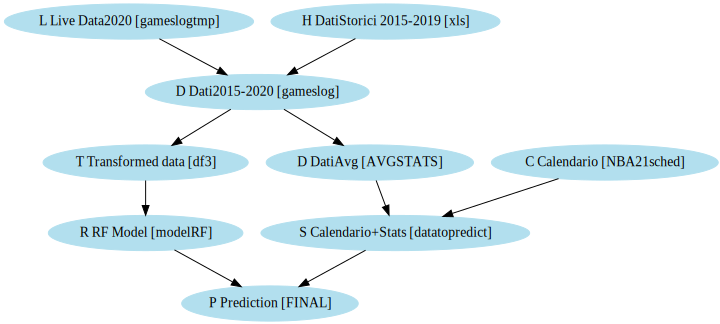

In [395]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

from graphviz import Digraph
dot = Digraph(comment='NBA Predict',node_attr={'color': 'lightblue2', 'style': 'filled'})
dot.attr(size='10,6')

dot.node('L', 'L Live Data2020 [gameslogtmp]')
dot.node('H', 'H DatiStorici 2015-2019 [xls]')
dot.node('D', 'D Dati2015-2020 [gameslog]')
dot.node('T', 'T Transformed data [df3]')
dot.node('R', 'R RF Model [modelRF]')
dot.node('A', 'D DatiAvg [AVGSTATS]')
dot.node('C', 'C Calendario [NBA21sched]')
dot.node('S', 'S Calendario+Stats [datatopredict]')
dot.node('P', 'P Prediction [FINAL]')
dot.edges(['LD','HD','DA','CS','AS','SP','RP','DT','TR'])
dot

# u.edge('5th Edition', 'PWB 1.0')
# u.edge('6th Edition', 'LSX')
# u.edge('6th Edition', '1 BSD')

### LOAD LOCAL DATABASE 

In [228]:
#LOAD LOCAL DATABASE 

import pandas as pd 
import datetime
import numpy as np

gameslogH = pd.read_excel('NBA2020analytics_gamesraw_backup.xls', index_col=0)  
print('gameslogH',gameslogH.shape)
gameslogH = gameslogH.dropna()
max = gameslogH ["GAME_DATE_EST"].max()
min = gameslogH ["GAME_DATE_EST"].min()
print(min,max)


gameslogH (23976, 31)
2015-12-26 00:00:00 2019-12-27 00:00:00


### QUERY NEW DATA

In [2]:

from tqdm import trange
from datetime import date
from datetime import datetime, timedelta
import datetime
from nba_api.stats.endpoints import scoreboardv2
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd 
import numpy as np

today = date.today()

gameslogtmp = []
for x in trange(365):
    d = datetime.date(2020, 12, 29)
    tmpdate = d - timedelta(x)
    output = scoreboardv2.ScoreboardV2(game_date=tmpdate, league_id='00',timeout=15000).get_data_frames()
    tmp = pd.DataFrame(output[1])
    gameslogtmp= tmp.append(gameslogtmp, ignore_index=True)



100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [07:29<00:00,  1.23s/it]


In [3]:
print('gameslogtmp',gameslogtmp.shape)
gameslogtmp = gameslogtmp.dropna()
max = gameslogtmp ["GAME_DATE_EST"].max()
min = gameslogtmp ["GAME_DATE_EST"].min()
print(min,max)

gameslogtmp (1570, 29)
2019-12-31T00:00:00 2020-12-28T00:00:00


### MERGE LOCAL WITH NEW DATA 
- gameslogH = dati caricati da XLS 
- gameslogtmp = dati new 
- gameslog = il DF finale, backuppato anche su csv e XLS 


In [195]:
print(gameslogH.shape)
print(gameslogtmp.shape)
gameslog=gameslogH.append(gameslogtmp)

import datetime 
gameslog['GAME_DATE_EST'] = pd.to_datetime(gameslog['GAME_DATE_EST']) # convert to date  
gameslog['YEAR'] = gameslog['GAME_DATE_EST'].dt.to_period('Y')  # create column Year
print(gameslog.groupby(['YEAR']).size())
print(gameslog ["GAME_DATE_EST"].min(),gameslog ["GAME_DATE_EST"].max())
print(gameslog.shape)

gameslog.to_csv('NBA2020analytics_gamesraw_backup.csv', index=False)
gameslog.to_excel('NBA2020analytics_gamesraw_backup.xls')

### Transform data in game data ( one line per match ) 

In [21]:

print('gameslog',gameslog.shape)

output = leaguedashteamstats.LeagueDashTeamStats(last_n_games='0', measure_type_detailed_defense='Base', month='0', opponent_team_id=0, pace_adjust='N', per_mode_detailed='Totals', period='0', plus_minus='N', rank='N', season='2019-20', season_type_all_star='Regular Season', conference_nullable='', date_from_nullable='', date_to_nullable='', division_simple_nullable='', game_scope_simple_nullable='', game_segment_nullable='', league_id_nullable='', location_nullable='', outcome_nullable='', po_round_nullable='', player_experience_nullable='', player_position_abbreviation_nullable='', season_segment_nullable='', shot_clock_range_nullable='', starter_bench_nullable='', team_id_nullable='', two_way_nullable='', vs_conference_nullable='', vs_division_nullable='').get_data_frames()
avg_stats = pd.DataFrame(output[0])
print('avg_stats',avg_stats.shape)
gameslog

df1=gameslog[['YEAR','GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID','TEAM_ABBREVIATION','TEAM_CITY_NAME','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2=df1[['YEAR','GAME_DATE_EST','GAME_ID','TEAM_ABBREVIATION','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2

df3 = pd.DataFrame([y.values.ravel() for x , y in df2.groupby(np.arange(len(df2))//2)])
df3.columns= ['YEARA','DATEA','GAME_IDA','TEAMA','PTSA','FG_PCTA','FT_PCTA','FG3_PCTA','ASTA','REBA','TOVA','YEARH','DATEH','GAME_IDH','TEAMH','PTSH','FG_PCTH','FT_PCTH','FG3_PCTH','ASTH','REBH','TOVH'] #COLUMNSRENAME
df3=df3[['YEARA','DATEA','GAME_IDH','TEAMH','PTSH','TEAMA','PTSA','FG_PCTH','FG_PCTA','FT_PCTH','FT_PCTA','FG3_PCTH','FG3_PCTA','ASTH','ASTA','REBH','REBA','TOVH','TOVA']] #COLUMNSSELECT
df3['WIN']=''

for i, row in df3.iterrows():
    if (row['PTSH']> row['PTSA']):
        df3.at[i,'WINTEAMNAME'] = row['TEAMH']
        df3.at[i,'WINTEAMNUM'] = 1
    else:
        df3.at[i,'WINTEAMNAME'] = row['TEAMH']
        df3.at[i,'WINTEAMNUM'] = 0

df3.head()
print(df3.groupby(['YEARA']).size())

gameslog (23976, 31)
avg_stats (30, 56)
YEARA
2015      98
2016    2870
2017    2852
2018    2792
2019    2609
2020     767
Freq: A-DEC, dtype: int64


In [27]:
df3.to_csv('NBA2020analytics_gamestransformed_backup.csv', index=False)
df3.to_excel('NBA2020analytics_gamestransformed_backup.xls')

### Create DecisionTree and Random Forest

In [3]:
# OPTIONAL - LOAD LOCAL gamestransformed FILE 

import pandas as pd 
import numpy as np
df3 = pd.read_excel('NBA2020analytics_gamestransformed_backup.xls', index_col=0)  
print('df3',df3.shape)
print(df3.groupby(['YEARA']).size())


df3 (11988, 22)
YEARA
2015      98
2016    2870
2017    2852
2018    2792
2019    2609
2020     767
dtype: int64


### 1 DecisionTree

In [73]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import tree

y = df3.WINTEAMNUM  #1 TEAMH , 0 TEAMA
df3_features = ['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']
X = df3[df3_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
print(train_X.shape,val_X.shape)

modelDT = DecisionTreeRegressor(max_leaf_nodes=10, random_state=1)
modelDT.fit(train_X, train_y)
preds_val = modelDT.predict(val_X)
print("DecisionTreeRegressor")
print(mean_absolute_error(val_y, preds_val))
modelDT_mae= mean_absolute_error(val_y, preds_val)


(8991, 12) (2997, 12)
DecisionTreeRegressor
0.3000791680852499


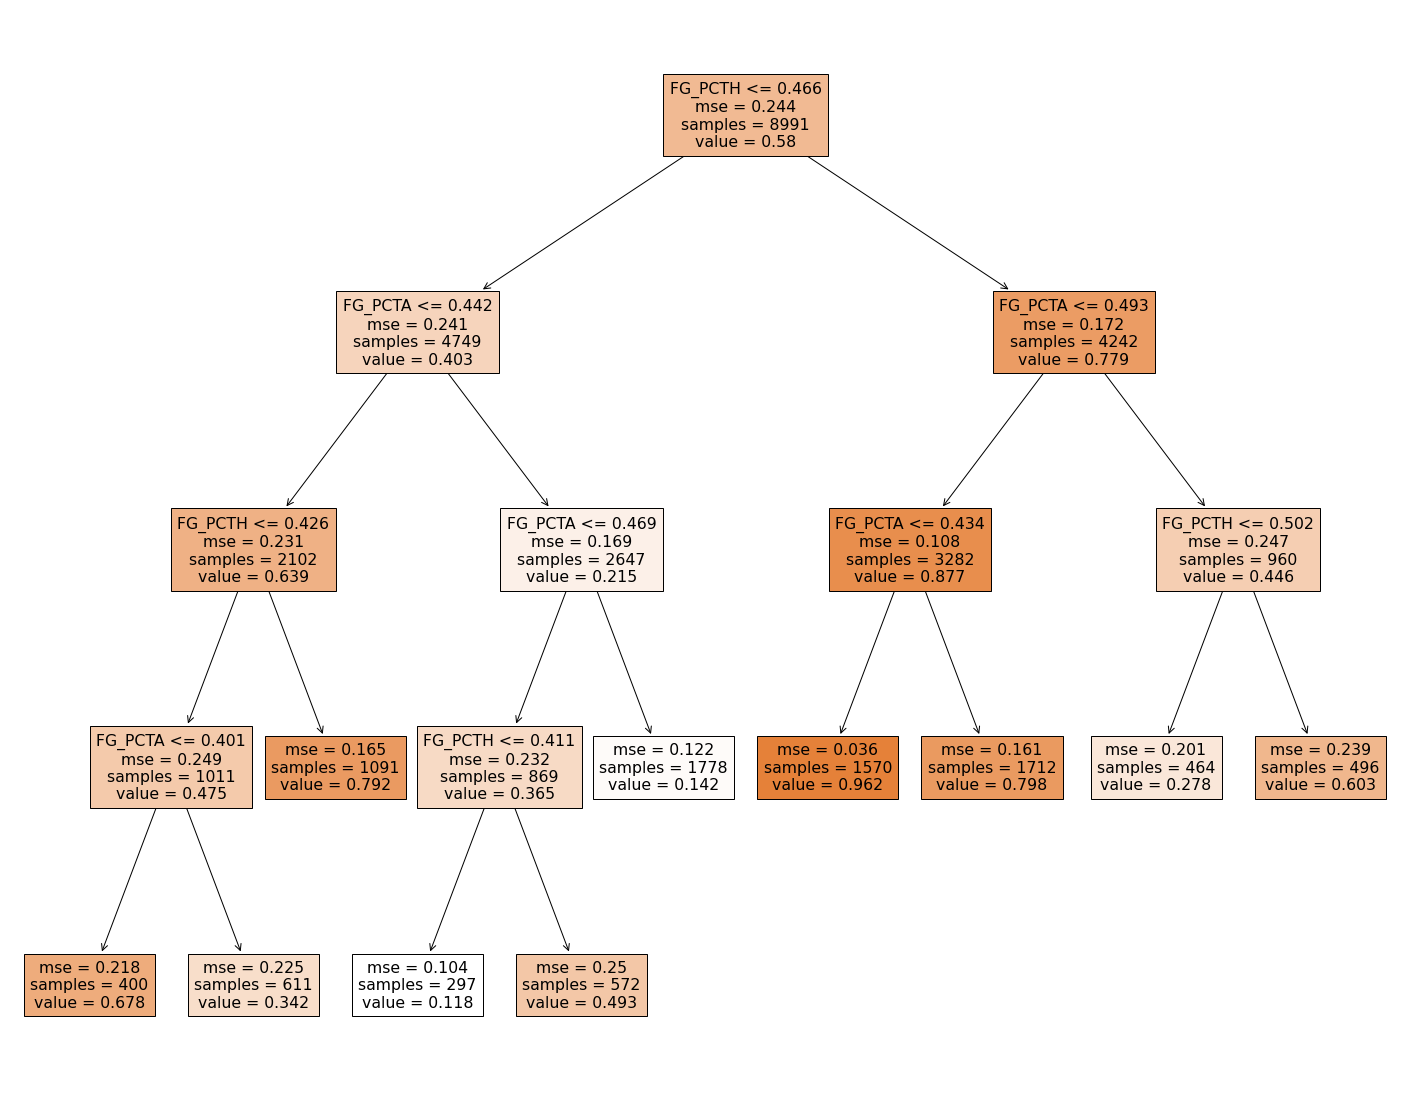

In [71]:
#https://mljar.com/blog/visualize-decision-tree/

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelDT,feature_names=val_X.columns, filled=True)

 #1 TEAMH , 0 TEAMA

In [72]:
# OPTIONAL - TEST MAX LEAF 

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

for max_leaf_nodes in [5,10,25,50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %f" %(max_leaf_nodes, my_mae))


Max leaf nodes: 5  		 Mean Absolute Error:  0.329103
Max leaf nodes: 10  		 Mean Absolute Error:  0.300079
Max leaf nodes: 25  		 Mean Absolute Error:  0.266252
Max leaf nodes: 50  		 Mean Absolute Error:  0.236297
Max leaf nodes: 500  		 Mean Absolute Error:  0.092674
Max leaf nodes: 5000  		 Mean Absolute Error:  0.060727


### 2 Random Forest

In [113]:
import time
start_time = time.time()
time.sleep(1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.000908613204956 seconds ---


In [169]:
import pandas as pd
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import tree

y = df3.WINTEAMNUM  #1 TEAMH , 0 TEAMA
df3_features = ['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']
X = df3[df3_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
print(train_X.shape,val_X.shape)

# #TEST TO OPTIMIZE n_estimators + max_depth
# start_time = time.time()
# for j in [1,2,25,50,100]:
#     modelRF = RandomForestClassifier(n_estimators=j,max_depth=25, random_state=0)
#     modelRF.fit(train_X, train_y)
#     preds_val = modelRF.predict(val_X)
#     modelRF_mae=mean_absolute_error(val_y, preds_val)
#     print("depth %.1f  mae %.4f " % (j,modelRF_mae))
# print("TOT seconds ","%.2f" %(time.time() - start_time))

start_time = time.time()
modelRF = RandomForestRegressor(max_depth=25, random_state=0)
modelRF.fit(train_X, train_y)
preds_val = modelRF.predict(val_X)
modelRF_mae=mean_absolute_error(val_y, preds_val)
print("RandomForestRegressor mae : %.4f " % (modelRF_mae))
print("TOT seconds ","%.2f" %(time.time() - start_time))


(8991, 12) (2997, 12)
RandomForestRegressor mae : 0.1221 
TOT seconds  3.55


In [162]:
import pickle
import sys

print("DT model size MB:", sys.getsizeof(pickle.dumps(modelDT))/1000000)
print("RF model size MB:", sys.getsizeof(pickle.dumps(modelRF))/1000000)

DT model size MB: 0.002213
RF model size MB: 11.292444


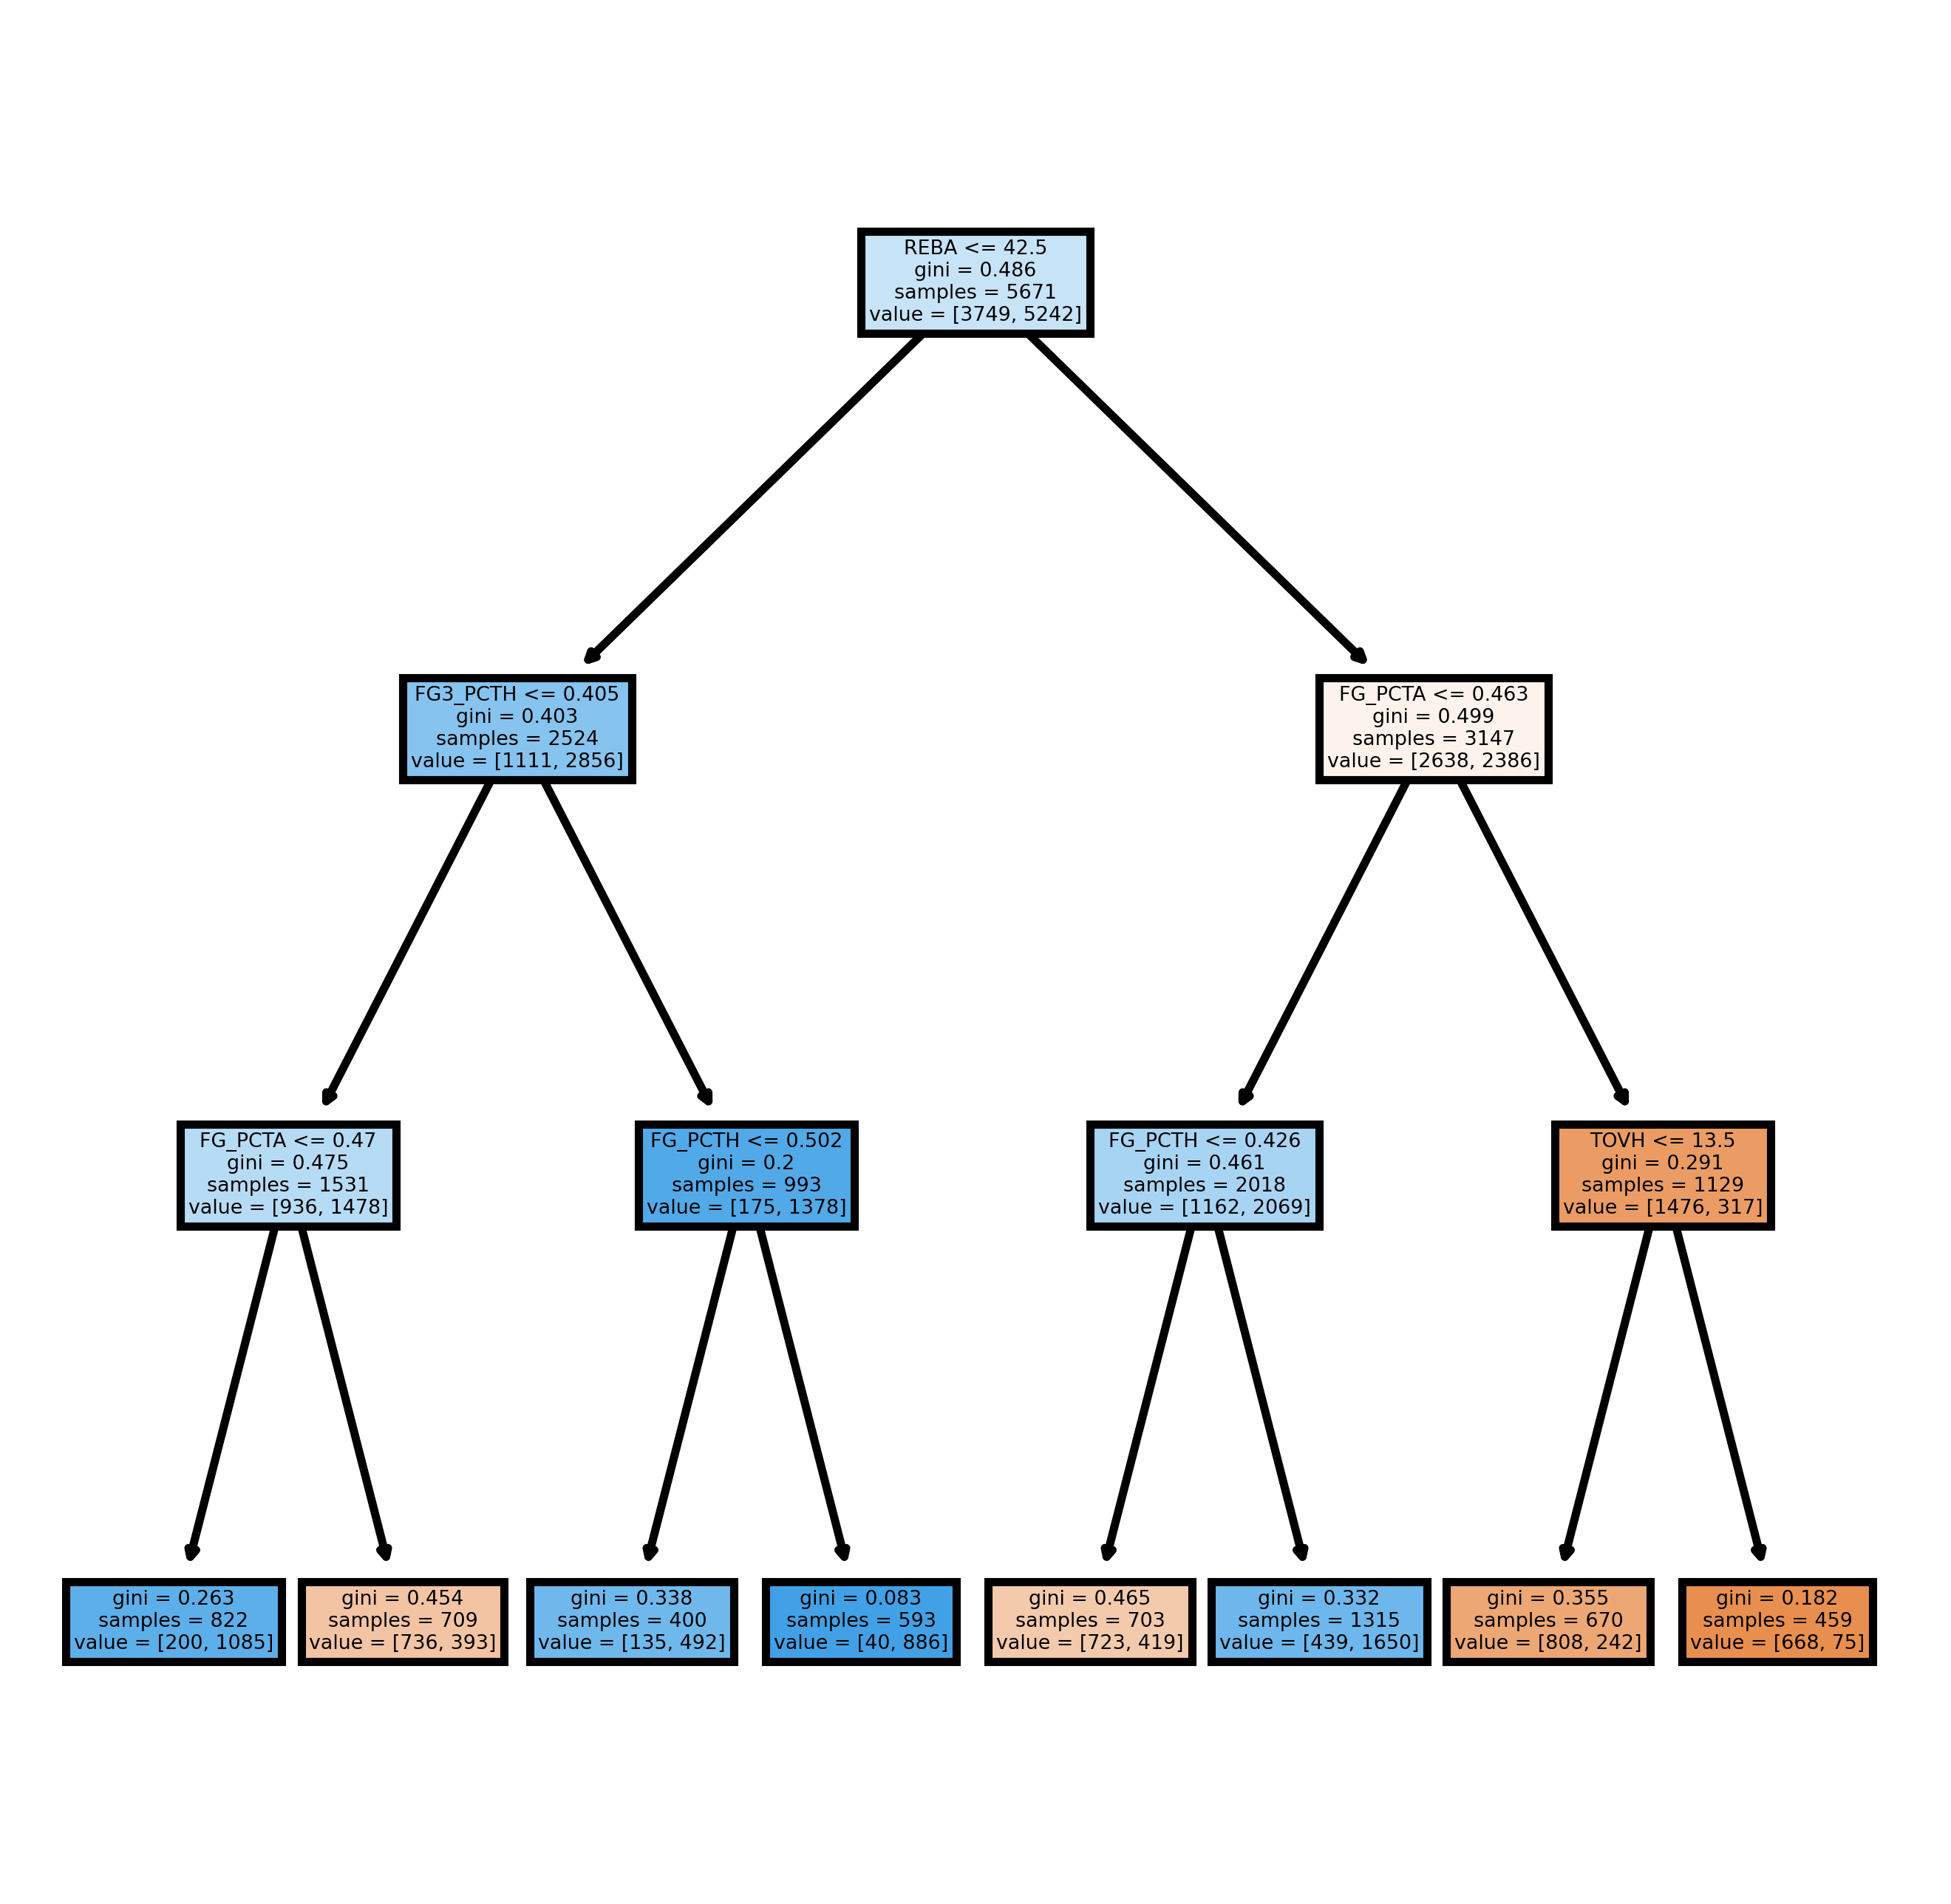

In [68]:
fn=train_X.columns
cn = ['0', '1']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(modelRF.estimators_[0],
               feature_names = fn, 
               filled = True);
fig.savefig('rf_individualtree.png')

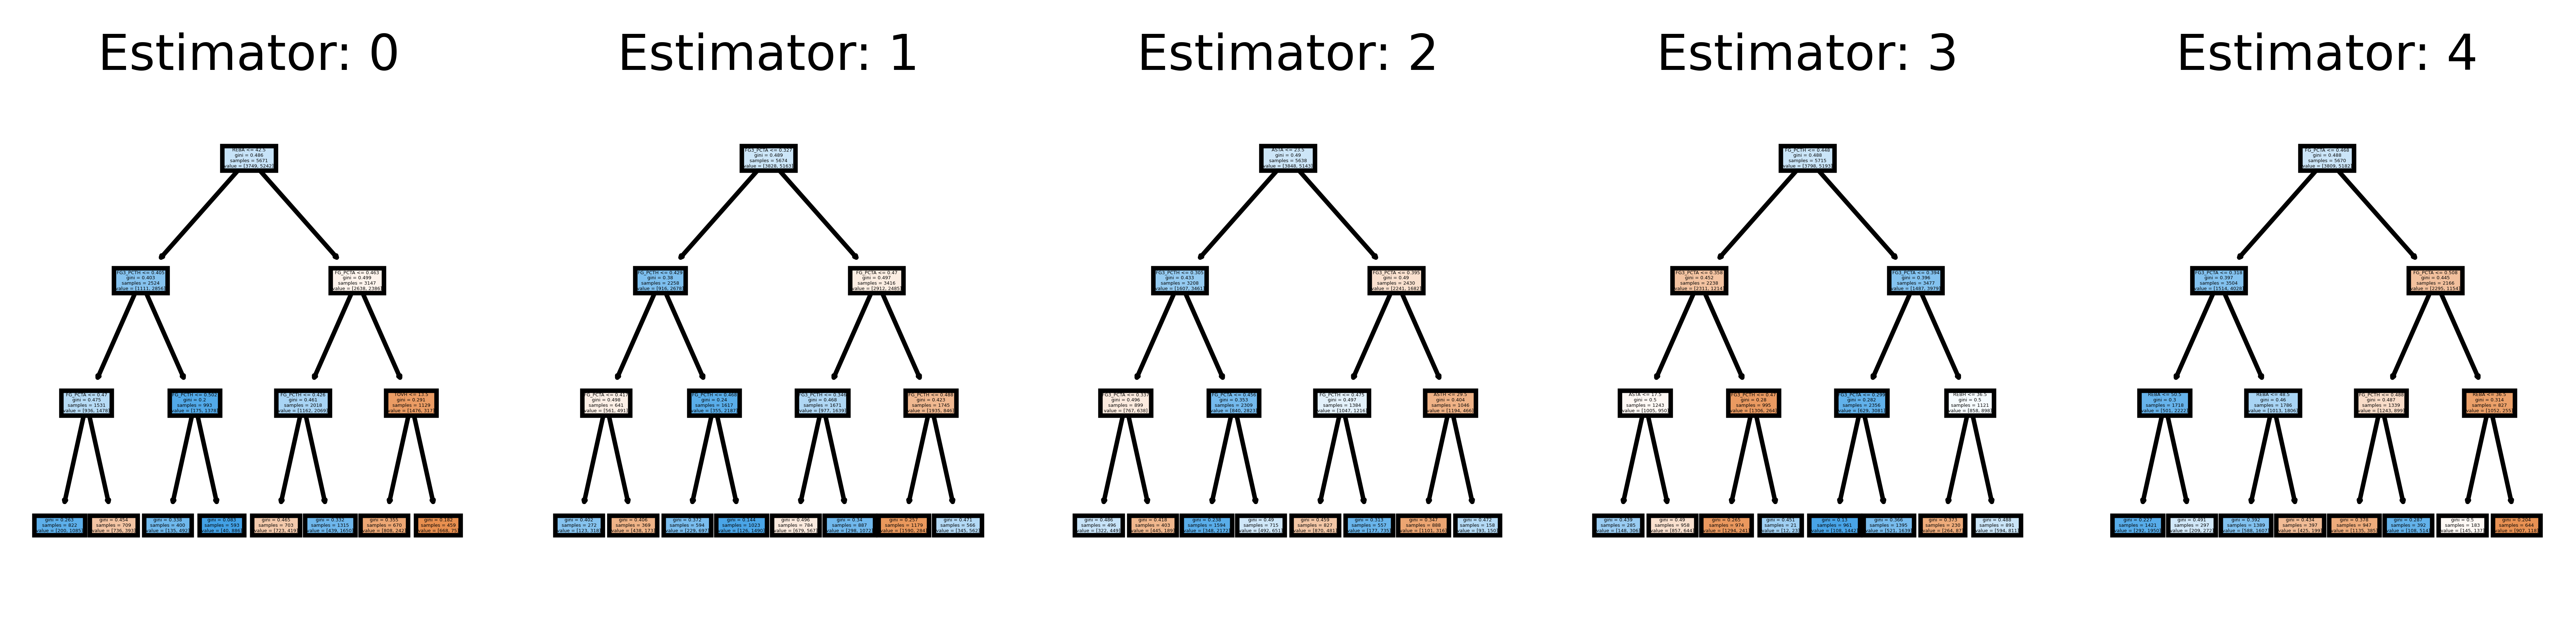

In [69]:
fn=train_X.columns
#cn=data.target_names
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(modelRF.estimators_[index],
                   feature_names = fn, 
 #                  class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

## PREDICTION WITH BOTH MODELS 

In [164]:
print('mean_absolute_error')
print('modelDT_mae:',modelDT_mae)
print('modelRF_mae:',modelRF_mae)

mean_absolute_error
modelDT_mae: 0.3000791680852499
modelRF_mae: 0.03970637303970637


In [170]:
# OPTIONAL - predict ON SYNTETIC RECORD . ONE RECORD DF

# #Xnew = ([-0.7,  2],[-8.25290074, -4.71455545],[-2.18773166,  3.33352125])
# Xnew, _ = make_blobs(n_samples=3, centers=2, n_features=2, random_state=1)

testarray = np.array(['0.350','0.460','0.722','0.765','0.429','0.400','35','31','57','60','15','18'])
columns =['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']
testdf = pd.DataFrame(testarray.reshape(-1, len(testarray)),columns=columns)
testdf

resultDT = modelDT.predict(testdf)
resultRF = modelRF.predict(testdf)

print('resultDT:',resultDT)
print('modelRF:',resultRF)

 #1 TEAMH , 0 TEAMA

resultDT: [0.11784512]
modelRF: [0.13]


In [320]:
# OPTIONAL - predict ON BIGGER DATAFRAME

testarray = np.array(['0.350','0.460','0.722','0.765','0.429','0.400','35','31','57','60','15','18'])
columns =['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']
testdf = pd.DataFrame(testarray.reshape(-1, len(testarray)),columns=columns)
testdf

resultDT = modelDT.predict(datatopredict)
resultRF = modelRF.predict(datatopredict)

np.set_printoptions(precision=2)
# print('resultDT:',resultDT)
# print('modelRF:',resultRF)

#1 TEAMH , 0 TEAMA
    
z = pd.DataFrame({'resultDT':resultDT, 'resultRF':resultRF})
z
z.shape

(468, 2)

In [380]:
import numpy as np
import pandas as pd

#1 LOAD CALENDAR

df = pd.read_csv("NBA2021schedule.csv",sep=";")
df=df.loc[df['Value'].str.startswith('@') == False]
df=df.rename(columns={"Value": "AWAY", "Attribute": "HOME"})
df = df[['GAMEDATE','HOME','AWAY']]
df['AWAY'] = df['AWAY'].apply(lambda x: x.upper())
df['HOME'] = df['HOME'].apply(lambda x: x.upper())
df= df.reset_index()
df['HOME'] = df['HOME'].str.replace('PHO','PHX')
df['AWAY'] = df['AWAY'].str.replace('PHO','PHX')
df['HOME'] = df['HOME'].str.replace('NOR','NOP')
df['AWAY'] = df['AWAY'].str.replace('NOR','NOP')
df['HOME'] = df['HOME'].str.replace('NO','NOP')
df['AWAY'] = df['AWAY'].str.replace('NO','NOP')
df['HOME'] = df['HOME'].str.replace('NY','NYK')
df['AWAY'] = df['AWAY'].str.replace('NY','NYK')
df['HOME'] = df['HOME'].str.replace('SA','SAS')
df['AWAY'] = df['AWAY'].str.replace('SA','SAS')
df['HOME'] = df['HOME'].str.replace('UTH','UTA')
df['AWAY'] = df['AWAY'].str.replace('UTH','UTA')
NBA21sched = df

#2 COMPUTE AVG STATS 

pandas.options.display.float_format = '{:,.2f}'.format
gameslogHZ=gameslogH.loc[gameslogH['YEAR'] == 2019]
gameslogHZ=gameslogHZ[['TEAM_ABBREVIATION','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
gameslogHP=gameslogHZ.groupby('TEAM_ABBREVIATION').mean().reset_index().sort_values(by='FG_PCT', ascending=False)
gameslogHP.head(2)

#3 MERGE CALENDAR + AVG STATS 

gameslogHP = gameslogHP.rename(columns={'TEAM_ABBREVIATION': 'HOME'})
tmpp = pd.merge(gameslogHP, NBA21sched)
tmpp.columns= ['HOME', 'PTSA', 'FG_PCTA', 'FT_PCTA', 'FG3_PCTA', 'ASTA', 'REBA', 'TOVA','index', 'GAMEDATE', 'AWAY']
gameslogHP = gameslogHP.rename(columns={'HOME': 'AWAY'})
tmp2 = pd.merge(gameslogHP, tmpp)
tmp2.columns = ['TEAMA', 'PTSH', 'FG_PCTH', 'FT_PCTH', 'FG3_PCTH', 'ASTH', 'REBH', 'TOVH','TEAMH','PTSA', 'FG_PCTA', 'FT_PCTA', 'FG3_PCTA', 'ASTA', 'REBA', 'TOVA','index', 'GAMEDATE']
AVGSTATS=tmp2[['GAMEDATE','TEAMH','PTSH','TEAMA','PTSA','FG_PCTH','FG_PCTA','FT_PCTH','FT_PCTA','FG3_PCTH','FG3_PCTA','ASTH','ASTA','REBH','REBA','TOVH','TOVA']] #COLUMNSSELECT
print(AVGSTATS.shape)

# 4 DATAFRAME datatopredict
AVGSTATS.head(3)
datatopredict=AVGSTATS[['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']]
datatopredict.head(3)

# 5 MAKE PREDICTION 

resultDT = modelDT.predict(datatopredict)
resultRF = modelRF.predict(datatopredict)
np.set_printoptions(precision=2)
PREDICT_OUT = pd.DataFrame({'resultDT':resultDT, 'resultRF':resultRF})
FINAL = pd.merge(PREDICT_OUT, datatopredict, left_index=True, right_index=True)
FINAL

#6 ADD TEAM INFO AND WINNER NAME

tmp21=AVGSTATS[['GAMEDATE', 'TEAMH','TEAMA']]
FINAL= pd.merge(FINAL, tmp21, left_index=True, right_index=True)

i=0
for index, row in tmp22.iterrows():
    FINAL.at[i, 'GAMEDATE2'] = datetime.strptime(row['GAMEDATE'], '%d/%m/%Y')
    FINAL.at[i, 'WINNER_ID'] = round(row['resultRF'])
    if (round(row['resultRF'])==0):    #1 TEAMH , 0 TEAMA
        win=row['TEAMA']
    else:
        win=row['TEAMH']
    FINAL.at[i, 'WINNER_NAME'] = win
    i=i+1

FINAL=FINAL.sort_values(by='GAMEDATE2', ascending=True)
FINAL


(468, 17)


,resultDT,resultRF,FG_PCTH,FG_PCTA,FT_PCTH,FT_PCTA,FG3_PCTH,FG3_PCTA,ASTH,ASTA,REBH,REBA,TOVH,TOVA,GAMEDATE,TEAMH,TEAMA,GAMEDATE2,WINNER_ID,WINNER_NAME
144,0.14,0.55,0.46,0.47,0.77,0.71,0.37,0.33,24.62,26.22,45.61,46.19,14.45,15.46,22/12/2020,LAL,LAC,2020-12-22,1.00,LAL
66,0.80,0.72,0.47,0.45,0.80,0.75,0.36,0.35,27.69,23.84,44.88,47.63,14.10,14.93,22/12/2020,BKN,GSW,2020-12-22,1.00,BKN
262,0.49,0.62,0.46,0.45,0.75,0.80,0.36,0.36,23.01,21.38,45.66,44.24,13.60,13.54,23/12/2020,HOU,OKC,2020-12-23,1.00,HOU
335,0.49,0.42,0.45,0.45,0.76,0.78,0.36,0.34,23.65,23.87,43.12,45.71,13.25,13.75,23/12/2020,MIN,DET,2020-12-23,0.00,DET
171,0.49,0.57,0.46,0.46,0.76,0.81,0.36,0.36,24.75,22.14,47.08,47.06,14.95,13.14,23/12/2020,POR,UTA,2020-12-23,1.00,POR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.14,0.10,0.46,0.47,0.75,0.79,0.36,0.38,23.01,24.26,45.66,45.29,13.60,12.33,04/03/2021,SAS,OKC,2021-03-04,0.00,OKC
226,0.49,0.53,0.46,0.46,0.81,0.80,0.37,0.36,25.34,25.08,45.04,45.17,13.43,12.88,04/03/2021,BOS,TOR,2021-03-04,1.00,BOS
96,0.80,0.57,0.47,0.46,0.73,0.74,0.36,0.35,25.28,26.11,45.50,46.40,14.82,15.05,04/03/2021,NOP,MIA,2021-03-04,1.00,NOP
147,0.49,0.55,0.46,0.47,0.77,0.78,0.37,0.36,24.62,27.20,45.61,43.23,14.45,13.56,04/03/2021,WAS,LAC,2021-03-04,1.00,WAS


In [381]:
FINAL.to_csv('NBA2020_Prediction_out.csv', index=False)
FINAL.to_excel('NBA2020_Prediction_out.xls')